# Synapse Dynamics
Author: Christian Pehle

In [2]:
from jaxsnn.channels import synapse as syn
from jaxsnn.base import explicit, funcutils
from jaxsnn.base.types import ArrayLike

from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import functools


import jax
import tree_math

In [3]:
def synapse_dynamics(p: syn.SynapseParameters):
    def dynamics(s, u):
        return syn.dynamics(s, p)

    return dynamics


ampa_dynamics = synapse_dynamics(syn.ampa_parameters)
nmda_dynamics = synapse_dynamics(syn.nmda_parameters)
gaba_dynamics = synapse_dynamics(syn.martinotti_gaba_parameters)

In [4]:
def synapse_projection(p: syn.SynapseParameters):
    def projection(x, u):
        x = syn.transition(w=u, s=x, p=p)
        return x

    return projection


ampa_projection = synapse_projection(syn.ampa_parameters)
nmda_projection = synapse_projection(syn.nmda_parameters)
gaba_projection = synapse_projection(syn.martinotti_gaba_parameters)

In [5]:
@tree_math.struct
class State:
    gaba: syn.SynapseState
    ampa: syn.SynapseState
    nmda: syn.SynapseState


@tree_math.struct
class Parameters:
    gaba: syn.SynapseParameters = syn.martinotti_gaba_parameters
    ampa: syn.SynapseParameters = syn.ampa_parameters
    nmda: syn.SynapseParameters = syn.nmda_parameters

In [6]:
def dynamics(s: State, _):
    return State(
        gaba=gaba_dynamics(s.gaba, _),
        ampa=ampa_dynamics(s.ampa, _),
        nmda=nmda_dynamics(s.nmda, _),
    )


def projection(x, u):
    return State(
        gaba=gaba_projection(x.gaba, u.gaba),
        ampa=ampa_projection(x.ampa, u.ampa),
        nmda=nmda_projection(x.nmda, u.nmda),
    )


def output(x, u):
    return x


equation = explicit.ExplicitConstrainedCDE(
    explicit_terms=dynamics, projection=projection, output=output
)

In [7]:
T = 2048
dt = 0.1
stim = np.zeros(T)
stim[1] = 1.0 # add a delta pulse

stim = State(ampa=stim, nmda=stim, gaba=stim)

step_fn = explicit.classic_rk4_cde(equation, dt)
integrator = funcutils.controlled_trajectory(step_fn, stim)
integrator = jax.jit(integrator)

In [8]:
s = syn.SynapseState(a=0.0, b=0.0)
s = State(ampa=s, gaba=s, nmda=s)
_, sol = integrator(s)

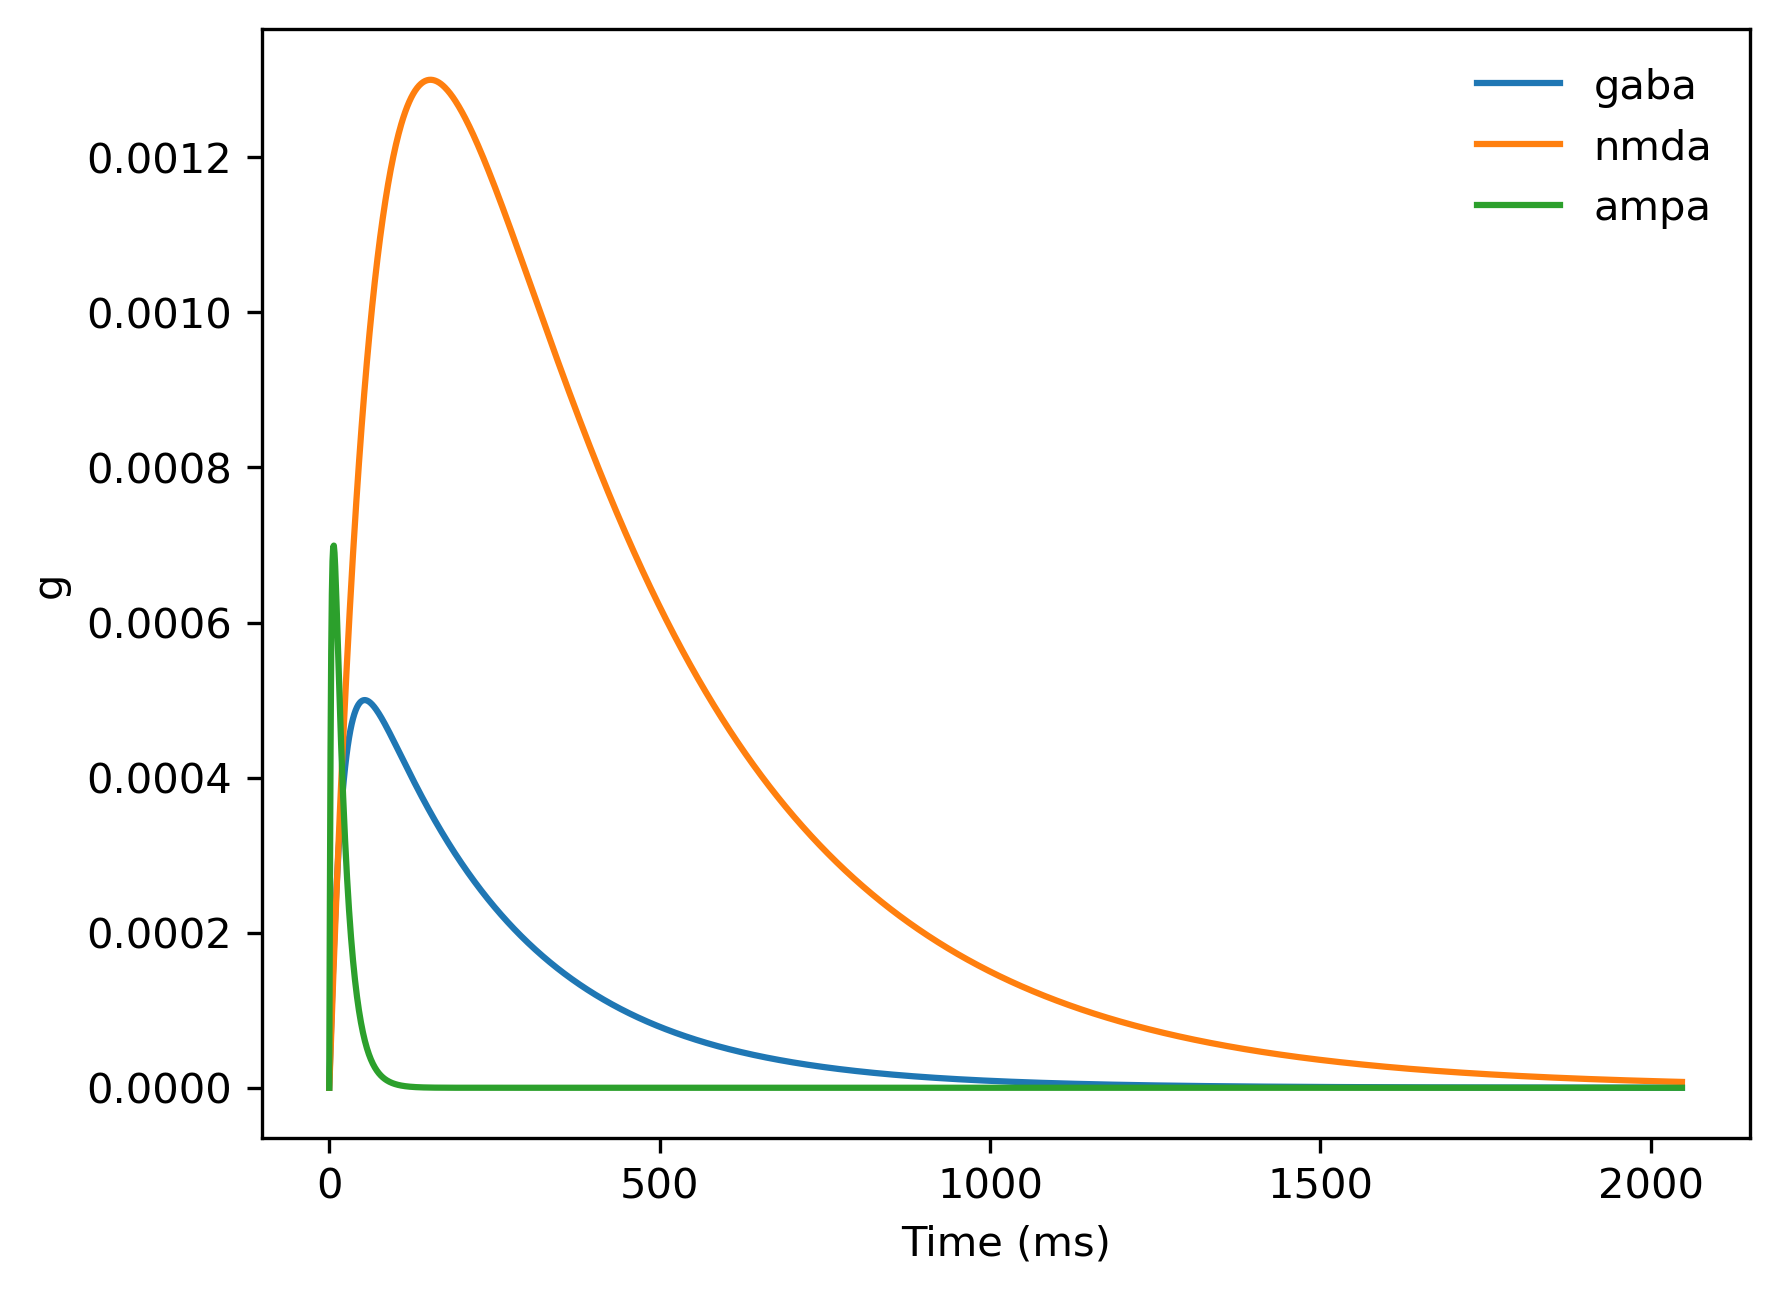

In [9]:
fig, ax = plt.subplots(1, 1, dpi=300)
ax.plot(syn.g_syn(sol.gaba, syn.martinotti_gaba_parameters), label="gaba")
ax.plot(syn.g_syn(sol.nmda, syn.nmda_parameters), label="nmda")
ax.plot(syn.g_syn(sol.ampa, syn.ampa_parameters), label="ampa")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("g")
ax.legend(loc="upper right", frameon=False)

In [10]:
fn = jax.value_and_grad(functools.partial(funcutils.controlled_trajectory, step_fn))

[]

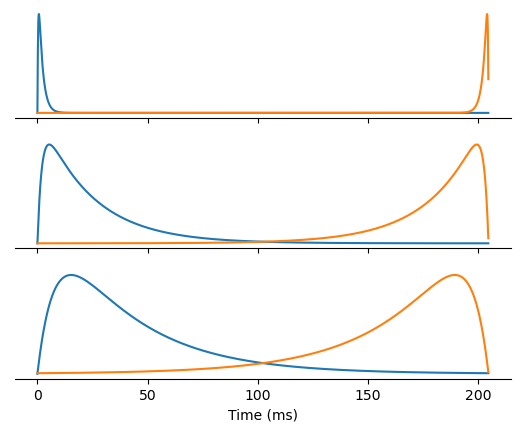

In [12]:
import jax.numpy as jnp

T = 2048
dt = 0.1
stim = np.zeros(T)
stim[1] = 1.0  # add a square pulse
stim = State(ampa=jnp.array(stim), nmda=jnp.array(stim), gaba=jnp.array(stim))

def input_integrator(stim):
    step_fn = explicit.classic_rk4_cde(equation, dt)
    integrator = funcutils.controlled_trajectory(step_fn, stim)
    s = syn.SynapseState(a=0.0, b=0.0)
    s = State(ampa=s, gaba=s, nmda=s)
    _, sol = integrator(s)
    return sol

def ampa_loss(stim):
    sol = input_integrator(stim)
    g = syn.g_syn(sol.ampa, syn.ampa_parameters)
    return g[-1] # error pulse at last timestep

def gaba_loss(stim):
    sol = input_integrator(stim)
    g = syn.g_syn(sol.gaba, syn.martinotti_gaba_parameters)
    return g[-1] # error pulse at last timestep

def nmda_loss(stim):
    sol = input_integrator(stim)
    g = syn.g_syn(sol.nmda, syn.nmda_parameters)
    return g[-1]

outs = []
grads = []

for loss in [ampa_loss, gaba_loss, nmda_loss]:
    fn = jax.value_and_grad(loss)
    out, grad = fn(stim)
    outs.append(out)
    grads.append(grad)

fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(dt*jnp.arange(0,T), syn.g_syn(input_integrator(stim).ampa, syn.ampa_parameters))
ax[0].spines["left"].set_color(None)
ax[0].spines["right"].set_color(None)
ax[0].spines["top"].set_color(None)
ax[0].set_yticks([])
ax[0].plot(dt*jnp.arange(0,T), grads[0].ampa)
ax[1].plot(dt*jnp.arange(0,T), syn.g_syn(input_integrator(stim).gaba, syn.martinotti_gaba_parameters))
ax[1].plot(dt*jnp.arange(0,T), grads[1].gaba)
ax[1].spines["left"].set_color(None)
ax[1].spines["right"].set_color(None)
ax[1].spines["top"].set_color(None)
ax[1].set_yticks([])
ax[2].plot(dt*jnp.arange(0,T), syn.g_syn(input_integrator(stim).nmda, syn.nmda_parameters))
ax[2].plot(dt*jnp.arange(0,T), grads[2].nmda)
ax[2].set_xlabel('Time (ms)')
ax[2].spines["left"].set_color(None)
ax[2].spines["right"].set_color(None)
ax[2].spines["top"].set_color(None)
ax[2].set_yticks([])
